In [1]:
if True:
    %matplotlib notebook
    figsize = (10,6)
else:
    figsize = (12,8)

from sps_engineering_Lib_dataQuery.databasemanager import DatabaseManager
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from matplotlib.dates import num2date
import datetime as dt

In [2]:
def outlierMask(array, outlierConstant=2.):
    lowerQuartile = np.percentile(array, 25)
    upperQuartile = np.percentile(array, 75)
    IQR = (upperQuartile - lowerQuartile) * outlierConstant

    return np.logical_and(array >= lowerQuartile - IQR, array <= upperQuartile + IQR)


def interpdate(datas):
    
    mintai = np.max([data.tai.min() for data in datas])
    maxtai = np.min([data.tai.max() for data in datas])
    tai = np.arange(mintai, maxtai, 0.0002)
    res = pd.DataFrame({'tai':tai})
    for data in datas:
        data = data.dropna()
        for col in data.columns[2:]:
            mask = outlierMask(data[col].values)
            nbOut = np.sum(~mask)
            if nbOut:
                print('col=%s nbOutliers=%d/%d'%(col, nbOut, len(mask)))
            res[col] = np.interp(res['tai'], data['tai'].values[mask], data[col].values[mask])
            
    return res

In [3]:
#Calibration 20°C step date

dates = {1:('2019-01-25 14:30', '2019-01-25 17:30'),
         2:('2019-01-30 17:30', '2019-01-30 20:30'),
         3:('2019-02-05 17:30', '2019-02-05 20:30'),
         4:('2019-02-11 13:30', '2019-02-11 16:30')}

In [4]:
db = DatabaseManager('tron', 5432, '')

In [5]:
db.init()

<connection object at 0x7f07946ee8c8; dsn: 'dbname='archiver' user='pfs' password=xx host='tron' port='5432'', closed: 0>

In [6]:
cols= ['val1_%d'%i for i in range(10)]

### SM Id

In [40]:
specId = 4
doCalc = False

In [41]:
datestart, dateend = dates[specId]

datafile = '/home/pfs/dev/SM_calibTemps/%s-SM%d-calibTemps_data.csv'%(datestart[:10], specId)
poptfile = '/home/pfs/dev/SM_calibTemps/%s-SM%d-calibTemps_popt.csv'%(datestart[:10], specId)

In [42]:
# Automatically Create 15,10,5,0 steps date

tempSteps = [15, 10, 5, 0] if specId != 3 else [15, 10, 5]
steps = {20: [datestart, dateend]}

for i, temp in enumerate(tempSteps):
    delta = dt.timedelta(hours=(i + 1) * 9)
    newstart = (dt.datetime.strptime(datestart, '%Y-%m-%d %H:%M') + delta).strftime('%Y-%m-%d %H:%M')
    newend = (dt.datetime.strptime(dateend, '%Y-%m-%d %H:%M') + delta).strftime('%Y-%m-%d %H:%M')

    steps[temp] = [newstart, newend]

if specId == 3:
    newstart, newend = '2019-02-07 09:30', '2019-02-07 12:30'
    steps[0] = [newstart, newend]

In [43]:
#Check that the steps are correct
if doCalc:
    std = []

    for start, end in steps.values():
        ref = db.dataBetween('aitroom__lake1', cols='temp1', start=start, end=end)
        stage1 = db.dataBetween('enu_sm0__temps1', cols=','.join(cols), start=start, end=end)
        stage2 = db.dataBetween('enu_sm0__temps2', cols=','.join(cols), start=start, end=end)
        stage1.columns = ['id','tai'] + ['%d'%i for i in range(101,111)]
        stage2.columns = ['id','tai'] + ['%d'%i for i in range(201,211)]
        datatemp = (interpdate([ref, stage1, stage2])).rolling(window=4,center=False).median().dropna()
        std.append(tuple([datatemp[col].std() for col in datatemp.columns[1:]]))

    std = pd.DataFrame(std, columns=datatemp.columns[1:])
    stdmean = np.mean(std.values)

    print('specId=%d, stdmean=%.7e'%(specId, stdmean))

In [44]:
#Extract reference temperature and sm sensors resistance, save the median
if doCalc:
    ohms = []
    datasets = []

    for start, end in steps.values():
        ref = db.dataBetween('aitroom__flowduino', cols='flow', start=start, end=end)
        ref.columns = ['id', 'tai'] + ['refTemp']
        print('%.3f+-%.3f' % (ref.refTemp.mean(), ref.refTemp.std()))
        stage1 = db.dataBetween('enu_sm0__res1', cols=','.join(cols), start=start, end=end)
        stage2 = db.dataBetween('enu_sm0__res2', cols=','.join(cols), start=start, end=end)
        stage1.columns = ['id', 'tai'] + ['%d' % i for i in range(101, 111)]
        stage2.columns = ['id', 'tai'] + ['%d' % i for i in range(201, 211)]
        dataset = interpdate([ref, stage1, stage2])
        ohms.append(tuple([dataset[col].median() for col in dataset.columns[1:]]))
        datasets.append(dataset)

    datasets = pd.concat(datasets)
    ohms = pd.DataFrame(ohms, columns=dataset.columns[1:])

In [45]:
if doCalc:
    popts = []
    temps = [ohms['refTemp'].values]

    for col in ohms.columns[1:]:
        popts.append(np.polyfit(ohms[col], ohms['refTemp'], deg=3))
        temps.append(np.polyval(popts[-1], ohms[col])-ohms['refTemp'].values)

    popts = pd.DataFrame(popts, index=dataset.columns[2:], columns=['c1', 'c2', 'c3', 'c4'])
    temps = pd.DataFrame(np.array(temps).transpose(), columns=ohms.columns)

    temps.set_index('refTemp').plot(figsize=(12,10), subplots=False, grid=True, title='Fit error')

In [46]:
if doCalc:
    datasets['tai'] = [date.isoformat()[:19] for date in num2date(datasets.tai)]
    datasets.to_csv(datafile)
    popts.to_csv(poptfile)

## Plot error with uncorrected values

In [47]:
datasets = []

for start, end in steps.values():
    ref = db.dataBetween('aitroom__lake1', cols='temp1', start=start, end=end)
    ref.columns = ['id', 'tai'] + ['refTemp']
    stage1 = db.dataBetween('enu_sm0__temps1', cols=','.join(cols), start=datestart, end=dateend)
    stage2 = db.dataBetween('enu_sm0__temps2', cols=','.join(cols), start=datestart, end=dateend)
    stage1.columns = ['id', 'tai'] + ['%d' % i for i in range(101, 111)]
    stage2.columns = ['id', 'tai'] + ['%d' % i for i in range(201, 211)]
    
    dataset = interpdate([ref, stage1, stage2])
    datasets.append(dataset)

datasets = pd.concat(datasets)

col=refTemp nbOutliers=11/720


<IPython.core.display.Javascript object>


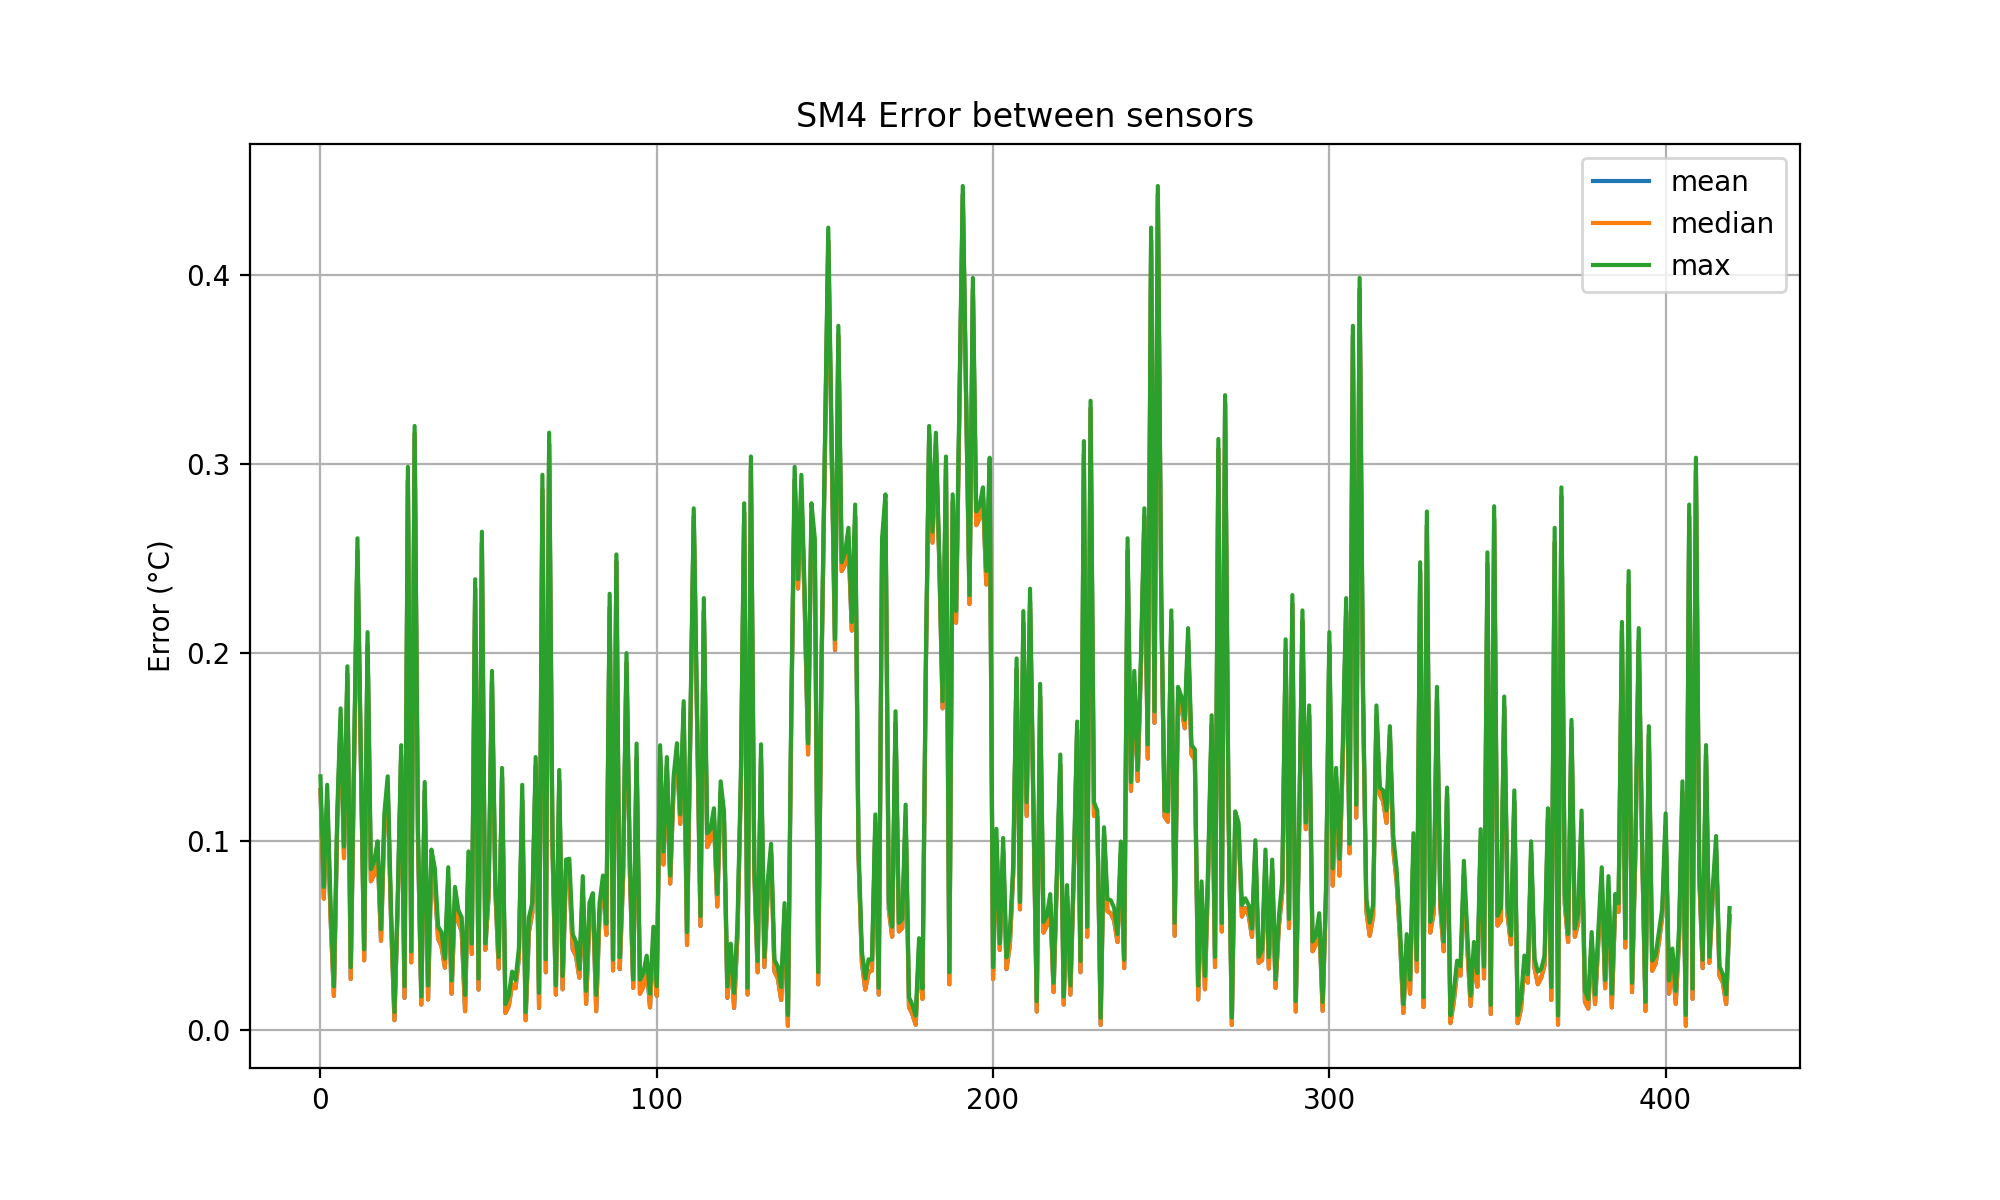

In [48]:
error = []

for ref in datasets.columns[1:]:
    temp = datasets.drop(columns=['tai', ref])
    for col in temp.columns:
        mat = np.abs(datasets[col] - datasets[ref])
        error.append((np.mean(mat), np.median(mat), np.max(mat)))
    
error = pd.DataFrame(error, columns=['mean','median','max'])
error.plot(figsize=figsize, grid=True, title='SM%d Error between sensors'%specId)

plt.ylabel('Error (°C)')
plt.savefig('/home/pfs/dev/SM_calibTemps/SM%d_errorNoCalib.png'%specId)

##  Plot error with corrected values

In [49]:
#Extract reference temperature and sm sensors resistance and recalibrate
popts = pd.read_csv(poptfile, index_col=0)

datasets = []

for start, end in steps.values():
    ref = db.dataBetween('aitroom__flowduino', cols='flow', start=start, end=end)
    ref.columns = ['id', 'tai'] + ['refTemp']
    stage1 = db.dataBetween('enu_sm0__res1', cols=','.join(cols), start=start, end=end)
    stage2 = db.dataBetween('enu_sm0__res2', cols=','.join(cols), start=start, end=end)
    stage1.columns = ['id', 'tai'] + ['%d' % i for i in range(101, 111)]
    stage2.columns = ['id', 'tai'] + ['%d' % i for i in range(201, 211)]
    
    dataset = interpdate([ref, stage1, stage2])
    for col, popt in popts.iterrows():
        dataset[str(col)] = np.polyval(popt, dataset[str(col)])

    datasets.append(dataset)

datasets = pd.concat(datasets)

col=209 nbOutliers=1/718
col=101 nbOutliers=3/720
col=204 nbOutliers=1/720
col=205 nbOutliers=2/720
col=206 nbOutliers=6/720
col=209 nbOutliers=2/720
col=201 nbOutliers=1/720
col=207 nbOutliers=1/720
col=202 nbOutliers=1/720
col=205 nbOutliers=1/720
col=207 nbOutliers=1/720
col=209 nbOutliers=1/720
col=210 nbOutliers=1/720
col=refTemp nbOutliers=11/720
col=101 nbOutliers=10/720
col=102 nbOutliers=8/720
col=103 nbOutliers=9/720
col=104 nbOutliers=10/720
col=105 nbOutliers=10/720
col=106 nbOutliers=9/720
col=107 nbOutliers=10/720
col=108 nbOutliers=10/720
col=109 nbOutliers=11/720
col=110 nbOutliers=9/720
col=201 nbOutliers=10/720
col=202 nbOutliers=9/720
col=203 nbOutliers=10/720
col=204 nbOutliers=10/720
col=205 nbOutliers=12/720
col=206 nbOutliers=10/720
col=207 nbOutliers=11/720
col=208 nbOutliers=8/720
col=209 nbOutliers=10/720
col=210 nbOutliers=10/720


<IPython.core.display.Javascript object>


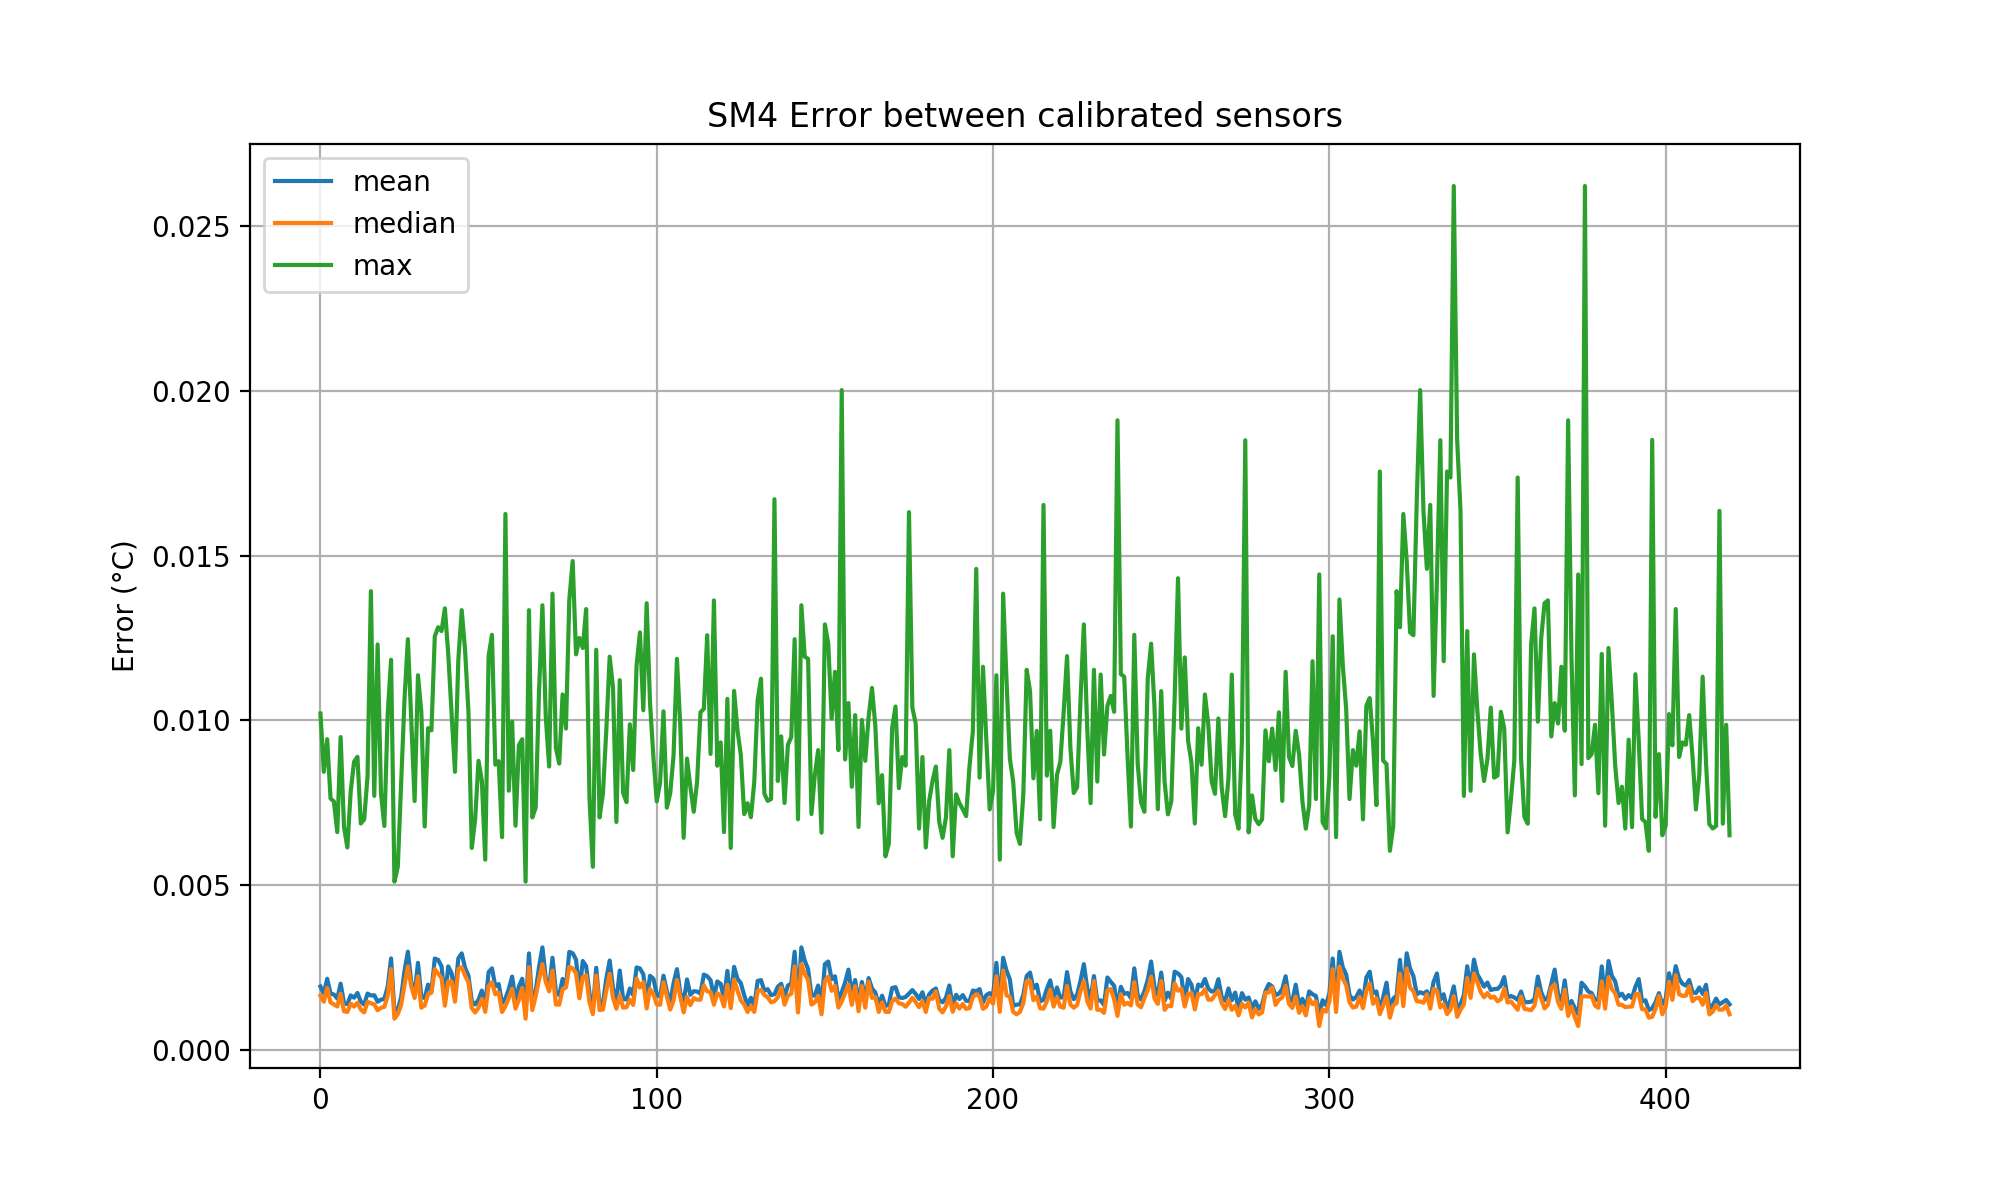

In [50]:
error = []

for ref in datasets.columns[1:]:
    temp = datasets.drop(columns=['tai', ref])
    for col in temp.columns:
        mat = np.abs(datasets[col] - datasets[ref])
        error.append((np.mean(mat), np.median(mat), np.max(mat)))
    
error = pd.DataFrame(error, columns=['mean','median','max'])
error.plot(figsize=figsize, grid=True, title='SM%d Error between calibrated sensors'%specId)
plt.ylabel('Error (°C)')
plt.savefig('/home/pfs/dev/SM_calibTemps/SM%d_errorWithCalib.png'%specId)

In [ ]:
popts=pd.read_csv(poptfile, index_col=0)
datasets = []

start=datestart
end = (dt.datetime.strptime(newend, '%Y-%m-%d %H:%M') + dt.timedelta(days=2)).strftime('%Y-%m-%d %H:%M')

ref = db.dataBetween('aitroom__flowduino', cols='flow', start=start, end=end)
ref.columns = ['id','tai'] + ['refTemp']
stage1 = db.dataBetween('enu_sm0__res1', cols=','.join(cols), start=start, end=end)
stage2 = db.dataBetween('enu_sm0__res2', cols=','.join(cols), start=start, end=end)
stage1.columns = ['id','tai'] + ['%d'%i for i in range(101,111)]
stage2.columns = ['id','tai'] + ['%d'%i for i in range(201,211)]
datasets.append(interpdate([ref, stage1, stage2]))
    
datasets = pd.concat(datasets)

In [ ]:
for col, popt in popts.iterrows():
    datasets[str(col)] = np.polyval(popt, datasets[str(col)])

In [ ]:
fig = plt.figure(figsize=figsize)

for col in datasets.columns[1:]:
    plt.plot_date(datasets.tai, datasets[col],'o', label='channel %s'%(col))
    
plt.grid()
plt.legend()
plt.ylim(-1,21)

In [ ]:
for channel, (c1,c2,c3,c4) in popts.iterrows():
    print('%s=%.7e,%7e,%.7e,%.7e'%(channel,c1,c2,c3,c4))